# CIFAR-10: Download & Load (Raw Format)

This notebook downloads the **raw CIFAR-10 (python version)**, extracts it, loads batches with pure Python/NumPy, and shows a sample image with its class name.


In [1]:
# --- Step 1: Download (original source) ---
# If this cell fails due to network restrictions in your environment,
# you can manually download the file and place it next to this notebook.
!wget -O cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

# --- Step 2: Extract (two-stage using gunzip, then tar) ---
# You asked to include !gunzip specifically; this expands the .tar.gz into a .tar
!gunzip -f cifar-10-python.tar.gz

# Now extract the resulting tar archive
!tar -xf cifar-10-python.tar

# The files will be in ./cifar-10-batches-py/
!ls -l cifar-10-batches-py | head -n 15


--2025-09-09 19:45:15--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  52.6MB/s    in 3.2s    

2025-09-09 19:45:19 (50.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

total 181876
-rw-r--r-- 1 codespace codespace      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 codespace codespace 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 codespace codespace 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 codespace codespace 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 codespace codespace 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 codespace codespace 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 codespace codespace       88 Jun  

In [2]:
# --- Step 3: Loader utilities (no Keras/torchvision) ---
import pickle
import numpy as np
import os

def load_cifar_batch(filename):
    """Load a single CIFAR-10 batch file and return (data, labels, filenames).
    - data: (N, 32, 32, 3) uint8
    - labels: (N,) int
    - filenames: list of N strings
    """
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')  # needed for python3
    data = batch['data']            # shape (10000, 3072)
    labels = batch.get('labels', batch.get('fine_labels'))  # fallback for CIFAR-100 style keys
    filenames = batch.get('filenames', None)
    
    # reshape to (N, 32, 32, 3) from channel-major flat (R 1024, G 1024, B 1024)
    data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
    return data, np.array(labels), filenames

def load_cifar_meta(root):
    """Load label names (class names) from batches.meta."""
    meta_path = os.path.join(root, 'batches.meta')
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f, encoding='latin1')
    # For CIFAR-10, 'label_names' is a list of 10 class names
    label_names = meta.get('label_names', None)
    return label_names

def load_cifar10(root='cifar-10-batches-py'):
    """Load entire CIFAR-10 (train + test). Returns:
        (X_train, y_train, X_test, y_test, class_names)
    Where:
        - X_* : (N, 32, 32, 3) uint8
        - y_* : (N,) int (0..9)
        - class_names: list of 10 strings
    """
    train_data, train_labels = [], []
    for i in range(1, 6):
        data, labels, _ = load_cifar_batch(os.path.join(root, f'data_batch_{i}'))
        train_data.append(data)
        train_labels.append(labels)
    X_train = np.concatenate(train_data, axis=0)
    y_train = np.concatenate(train_labels, axis=0)

    X_test, y_test, _ = load_cifar_batch(os.path.join(root, 'test_batch'))
    class_names = load_cifar_meta(root)
    return X_train, y_train, X_test, y_test, class_names


In [3]:
# --- Step 4: Load all data ---
X_train, y_train, X_test, y_test, class_names = load_cifar10('cifar-10-batches-py')
print('Train:', X_train.shape, y_train.shape, X_train.dtype)
print('Test :', X_test.shape, y_test.shape, X_test.dtype)
print('Classes:', class_names)


Train: (50000, 32, 32, 3) (50000,) uint8
Test : (10000, 32, 32, 3) (10000,) uint8
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


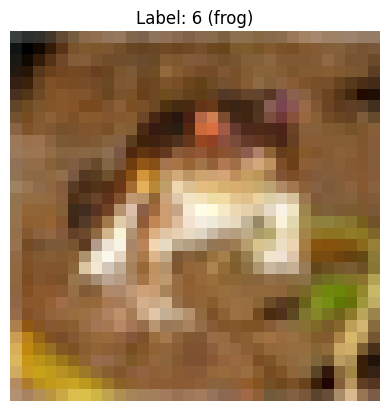

In [4]:
# --- Step 5: Visualize one sample ---
import matplotlib.pyplot as plt

idx = 0  # try different numbers to preview other images
img = X_train[idx]
label = y_train[idx]
name = class_names[label] if class_names else str(label)

plt.imshow(img)
plt.title(f'Label: {label} ({name})')
plt.axis('off')
plt.show()
